# Network parameters

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
N_BATCH=32
EPOCHS=100
PATIENCE=10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=PATIENCE)

# Load libraries

In [3]:
import cnn_models
import data_preparation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.svm import SVC
import data_augmentation
import random
from sklearn.preprocessing import StandardScaler

/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Set seed for reproducibility

In [4]:
SEED = 10
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED)

# Load dataset
## No augmentation

In [5]:
fsdd_dir="./recordings/"
our_recs_dir="./preprocessed_recs/"

In [6]:
recordings = data_preparation.load_recordings(paths=[fsdd_dir, our_recs_dir])

Loading from ./recordings/



Loading from ./preprocessed_recs/


How much does input recordings vary?

In [7]:
min_y = min(map(np.shape, recordings))[0]
max_y = max(map(np.shape, recordings))[0]
print(min_y, max_y)

1010 18262


It's quite a huge difference! Let's find out the 10 longest recordings:

In [8]:
a = [len(x) for x in recordings]
a.sort(reverse=True)
a[0:10]

[18262, 17567, 9015, 8995, 8435, 8281, 8201, 8068, 7755, 7356]

Let's now get their indexes:

In [9]:
a = [len(x) for x in recordings]
first_length=18262
second_length=17567
index_first = a.index(first_length)
index_second = a.index(second_length)

In [10]:
labels_speakers = data_preparation.load_labels(paths=[fsdd_dir, our_recs_dir], label_type="speakers")
labels_digits = data_preparation.load_labels(paths=[fsdd_dir, our_recs_dir])
print("Longest track is associated with speaker {}, digit {}".format(labels_speakers[index_first],labels_digits[index_first]))
print("Second longest track is associated with speaker {}, digit {}".format(labels_speakers[index_second],labels_digits[index_second]))

Longest track is associated with speaker theo, digit 9
Second longest track is associated with speaker theo, digit 7


So the problem is with theo, which has 500 recordings, digit 9 and 7, which respectively have 200 recordings. We can safely delete them and saving to pad many thousands of 0s (there will be (18262 - 9015) less zeros)

In [11]:
max_track_length=9015 # it will be useful later on
print("Before: {}".format(len(recordings)))
recordings=np.delete(recordings,[index_first, index_second])
print("After: {}".format(len(recordings)))

Before: 2400
After: 2398


In [12]:
print("Before: {}".format(len(labels_speakers)))
labels_speakers=np.delete(labels_speakers,[index_first, index_second])
print("After: {}".format(len(labels_speakers)))

Before: 2400
After: 2398


In [13]:
print("Before: {}".format(len(labels_digits)))
labels_digits=np.delete(labels_digits,[index_first, index_second])
print("After: {}".format(len(labels_digits)))

Before: 2400
After: 2398


Let's now double check to see if everything went well. Now the longest recording will be around 9 K

In [14]:
a = [len(x) for x in recordings]
a.sort(reverse=True)
a[0:10]

[9015, 8995, 8435, 8281, 8201, 8068, 7755, 7356, 7147, 7038]

Even though variability is reduced, it is still there: for this reason we will pad zeros at start and end of recordings

In [15]:
pad_recordings = data_preparation.pad_zeros(recordings)

Now they will have the same length:

In [16]:
min_y = min(map(np.shape, pad_recordings))[0]
max_y = max(map(np.shape, pad_recordings))[0]
print(min_y, max_y)

9015 9015


Now we will create balancede train, validation and test sets. For digits it's not a huge problem (only 7 and 9, because of the previous operation, have 1 recordings less, however our 4 speakers (ale, alinda, gian, khaled) have 100 recordings, while the other 4 have 500 recordings.

In [17]:
X, y = data_preparation.balanced_train_val_test_split(pad_recordings, labels_digits)
X_train_digits = X[0]
y_train_digits = y[0]
X_val_digits = X[1]
y_val_digits = y[1] 
X_test_digits = X[2]
y_test_digits = y[2] 

In [18]:
X, y = data_preparation.balanced_train_val_test_split(pad_recordings, labels_speakers)
X_train_speakers = X[0]
y_train_speakers = y[0]
X_val_speakers = X[1]
y_val_speakers = y[1] 
X_test_speakers = X[2]
y_test_speakers = y[2] 

# Digits
## Spectrograms - No augmentation

In [19]:
%%time
X_train_digits_spects = np.array([data_preparation.compute_spectrogram(x) for x in X_train_digits])
X_val_digits_spects = np.array([data_preparation.compute_spectrogram(x) for x in X_val_digits])
X_test_digits_spects = np.array([data_preparation.compute_spectrogram(x) for x in X_test_digits])

CPU times: user 23.3 s, sys: 393 ms, total: 23.6 s
Wall time: 14.7 s


In [20]:
%%time
X_train_digits_spects_norm = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_train_digits])
X_val_digits_spects_norm = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_val_digits])
X_test_digits_spects_norm = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_test_digits])

CPU times: user 23.1 s, sys: 351 ms, total: 23.5 s
Wall time: 13.5 s


In [21]:
nsamples, nx, ny = X_train_digits_spects.shape
X_train_digits_spects_2d = X_train_digits_spects.reshape((nsamples, nx * ny))

In [22]:
%%time
clf1 = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf1 = clf1.fit(X_train_digits_spects_2d, y_train_digits)

CPU times: user 8.75 s, sys: 67.3 ms, total: 8.81 s
Wall time: 9.02 s


In [23]:
nsamples, nx, ny = X_val_digits_spects.shape
X_val_digits_spects_2d = X_val_digits_spects.reshape((nsamples, nx * ny))

In [24]:
%%time
y_pred = clf1.predict(X_val_digits_spects_2d)
print(classification_report(y_val_digits, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        48
           1       0.69      0.23      0.34        48
           2       0.62      0.17      0.26        48
           3       0.56      0.19      0.28        48
           4       0.13      0.50      0.21        48
           5       0.64      0.19      0.29        48
           6       0.13      0.52      0.20        48
           7       0.70      0.15      0.24        48
           8       0.80      0.08      0.15        48
           9       0.93      0.27      0.42        48

    accuracy                           0.25       480
   macro avg       0.62      0.25      0.27       480
weighted avg       0.62      0.25      0.27       480

CPU times: user 1.75 s, sys: 18.7 ms, total: 1.77 s
Wall time: 1.88 s


Normalized spectrograms

In [25]:
nsamples, nx, ny = X_train_digits_spects_norm.shape
X_train_digits_spects_norm_2d = X_train_digits_spects_norm.reshape((nsamples, nx * ny))

In [26]:
%%time
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_digits_spects_norm_2d, y_train_digits)

CPU times: user 4.11 s, sys: 32.9 ms, total: 4.14 s
Wall time: 4.28 s


In [27]:
nsamples, nx, ny = X_val_digits_spects_norm.shape
X_val_digits_spects_norm_2d = X_val_digits_spects_norm.reshape((nsamples, nx * ny))

In [28]:
%%time
y_pred = clf.predict(X_val_digits_spects_norm_2d)
print(classification_report(y_val_digits, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.90      0.90      0.90        48
           2       0.87      0.94      0.90        48
           3       0.96      0.90      0.92        48
           4       1.00      0.85      0.92        48
           5       0.93      0.88      0.90        48
           6       0.85      0.92      0.88        48
           7       0.87      0.98      0.92        48
           8       0.90      0.90      0.90        48
           9       0.91      0.85      0.88        48

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480

CPU times: user 1.52 s, sys: 16.9 ms, total: 1.54 s
Wall time: 1.68 s


Normalized spectrograms lead to better performances, therefore let's use this representation as default
### CNN

In [29]:
X_data, y_data, input_shape, _ = data_preparation.prepare_data_nn(X_train_digits_spects_norm, X_val_digits_spects_norm, X_test_digits_spects_norm, y_train_digits, y_val_digits, y_test_digits, number_mode=True)

X_train_digits_spects_norm_nn  = X_data[0]
y_train_digits_nn = y_data[0]
X_val_digits_spects_norm_nn  = X_data[1]
y_val_digits_nn = y_data[1]
X_test_digits_spects_norm_nn = X_data[2]
y_test_digits_nn  = y_data[2]


In [30]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10)
model.fit(X_train_digits_spects_norm_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_spects_norm_nn, y_val_digits_nn))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 17, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 8, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16128)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1032256   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 1,033,066
Trainable params: 1,033,066
Non-trainable params: 0
______________________________________________

In [31]:
y_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_spects_norm_nn)
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.87      1.00      0.93        48
           2       0.96      0.94      0.95        48
           3       0.94      0.94      0.94        48
           4       0.98      0.96      0.97        48
           5       1.00      0.94      0.97        48
           6       0.88      0.94      0.91        48
           7       0.98      0.98      0.98        48
           8       0.94      0.92      0.93        48
           9       0.95      0.83      0.89        48

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480



In [32]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10, batch_normalisation=True)
model.fit(X_train_digits_spects_norm_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_spects_norm_nn, y_val_digits_nn))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 17, 32)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 17, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 8, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1032256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.2689 - val_accuracy: 0.9604
Epoch 47/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.2740 - val_accuracy: 0.9563
Epoch 48/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.2665 - val_accuracy: 0.9604
Epoch 49/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.2675 - val_accuracy: 0.9583
Epoch 50/100
1430/1430 [==============================] - 4s 2ms/sample - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.2705 - val_accuracy: 0.9583
Epoch 51/100
1430/1430 [==============================] - 3s 2ms/sample - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.2738 - val_accuracy: 0.9563
Epoch 52/100
1430/1430 [==============================] - 4s 2ms/sample - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.2685 

In [33]:
y_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_spects_norm_nn)
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       0.96      0.94      0.95        48
           2       0.96      0.94      0.95        48
           3       0.96      0.98      0.97        48
           4       1.00      0.96      0.98        48
           5       0.94      0.96      0.95        48
           6       0.94      0.96      0.95        48
           7       1.00      0.94      0.97        48
           8       0.98      1.00      0.99        48
           9       0.88      0.94      0.91        48

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



Let's now try with MFCCs
## MFCC - No augmentation

In [34]:
%%time
X_train_digits_mfcc= np.array([data_preparation.mfcc(x, flatten=True) for x in X_train_digits])
X_val_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_val_digits])
X_test_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_test_digits])

CPU times: user 22.4 s, sys: 353 ms, total: 22.8 s
Wall time: 11.9 s


In [35]:
%time
scaler_normal = StandardScaler()
X_train_digits_mfcc_scaled = scaler_normal.fit_transform(X_train_digits_mfcc)
X_val_digits_mfcc_scaled =  scaler_normal.transform(X_val_digits_mfcc)
X_test_digits_mfcc_scaled =  scaler_normal.transform(X_test_digits_mfcc)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


### SVC

In [36]:
%%time
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_digits_mfcc_scaled, y_train_digits)

CPU times: user 722 ms, sys: 12 ms, total: 734 ms
Wall time: 818 ms


In [37]:
%%time
y_pred = clf.predict(X_val_digits_mfcc_scaled)
print(classification_report(y_val_digits, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        48
           1       0.98      0.98      0.98        48
           2       1.00      1.00      1.00        48
           3       0.96      0.96      0.96        48
           4       1.00      0.88      0.93        48
           5       1.00      0.92      0.96        48
           6       0.69      0.92      0.79        48
           7       1.00      0.96      0.98        48
           8       0.92      0.94      0.93        48
           9       0.98      0.94      0.96        48

    accuracy                           0.94       480
   macro avg       0.95      0.94      0.94       480
weighted avg       0.95      0.94      0.94       480

CPU times: user 244 ms, sys: 5.28 ms, total: 249 ms
Wall time: 310 ms


Similar results of the best Spectrograms model. Let's now use CNNs with MFCC
### CNN

In [38]:
%%time
X_train_digits_mfcc= np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_digits])
X_val_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_digits])
X_test_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_digits])

CPU times: user 22.6 s, sys: 360 ms, total: 22.9 s
Wall time: 12 s


In [39]:
X_train_digits_mfcc.shape

(1430, 20, 18)

In [40]:
X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digits_mfcc, X_val_digits_mfcc, X_test_digits_mfcc, y_train_digits, y_val_digits, y_test_digits, number_mode=True)

X_train_digits_mfcc_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_mfcc_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_mfcc_nn = X[2]
y_test_digits_nn = y[2]

In [41]:
input_shape

(20, 18, 1)

We can now start to train the models, let's start with the simpler one:

In [42]:
%%time
model = cnn_models.simple_model(input_shape=input_shape,
                                num_classes=10)
model.fit(X_train_digits_mfcc_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_mfcc_nn, y_val_digits_nn))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                147520    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 148,330
Trainable params: 148,330
Non-trainable params: 0
________________________________________________

1430/1430 [==============================] - 1s 636us/sample - loss: 2.3027 - accuracy: 0.0902 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 48/100
1430/1430 [==============================] - 1s 612us/sample - loss: 2.3027 - accuracy: 0.0790 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 49/100
1430/1430 [==============================] - 1s 589us/sample - loss: 2.3027 - accuracy: 0.0818 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 50/100
1430/1430 [==============================] - 1s 586us/sample - loss: 2.3027 - accuracy: 0.0930 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 51/100
1430/1430 [==============================] - 1s 600us/sample - loss: 2.3027 - accuracy: 0.0853 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 52/100
1430/1430 [==============================] - 1s 601us/sample - loss: 2.3027 - accuracy: 0.0937 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 53/100
1430/1430 [==============================] - 1s 603us/sample - loss: 2.3027 - accuracy: 0.0874 - val

In [43]:
Y_val_nn = np.argmax(y_val_digits_nn,  axis=1)
y_pred = model.predict_classes(X_val_digits_mfcc_nn)
print(classification_report(Y_val_nn, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        48
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        48
           8       0.10      1.00      0.18        48
           9       0.00      0.00      0.00        48

    accuracy                           0.10       480
   macro avg       0.01      0.10      0.02       480
weighted avg       0.01      0.10      0.02       480



/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Really poor results, let's now use batch normalisation:

In [44]:
%%time
model = cnn_models.simple_model(input_shape=input_shape,
                                num_classes=10,
                                batch_normalisation=True)
model.fit(X_train_digits_mfcc_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_mfcc_nn, y_val_digits_nn))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                147520    
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

1430/1430 [==============================] - 1s 742us/sample - loss: 0.0459 - accuracy: 0.9972 - val_loss: 0.2176 - val_accuracy: 0.9479
Epoch 47/100
1430/1430 [==============================] - 1s 719us/sample - loss: 0.0414 - accuracy: 0.9930 - val_loss: 0.1988 - val_accuracy: 0.9521
Epoch 48/100
1430/1430 [==============================] - 1s 766us/sample - loss: 0.0409 - accuracy: 0.9944 - val_loss: 0.2124 - val_accuracy: 0.9500
Epoch 49/100
1430/1430 [==============================] - 1s 767us/sample - loss: 0.0429 - accuracy: 0.9965 - val_loss: 0.2060 - val_accuracy: 0.9500
Epoch 50/100
1430/1430 [==============================] - 1s 741us/sample - loss: 0.0384 - accuracy: 0.9986 - val_loss: 0.2049 - val_accuracy: 0.9458
Epoch 51/100
1430/1430 [==============================] - 1s 752us/sample - loss: 0.0487 - accuracy: 0.9923 - val_loss: 0.2110 - val_accuracy: 0.9521
Epoch 52/100
1430/1430 [==============================] - 1s 734us/sample - loss: 0.0378 - accuracy: 0.9986 - val

In [45]:
Y_val_nn = np.argmax(y_val_digits_nn,  axis=1)
y_pred = model.predict_classes(X_val_digits_mfcc_nn)
print(classification_report(Y_val_nn, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.98      1.00      0.99        48
           2       0.92      1.00      0.96        48
           3       0.96      0.98      0.97        48
           4       1.00      0.98      0.99        48
           5       0.96      0.94      0.95        48
           6       0.96      0.94      0.95        48
           7       0.98      0.98      0.98        48
           8       0.96      0.96      0.96        48
           9       0.96      0.92      0.94        48

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



The best combo so far is "CNN + MFCCs".

Batch normalisation lead to similar results on spectrograms, however on MFCC it works way better.

## Augmentation - MFCC

In [46]:
%%time
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                                                    y_type= ['digit', 'digit'],
                                                    n_category_test=15,
                                                    include_pitch=True,
                                                    max_length=max_track_length,
                                                    recordings_source=[False, True],
                                                    transform_function="mfcc")
X_train_digit_mfcc = X[0]
y_train_digit_mfcc = y[0]
X_val_digit_mfcc = X[1]
y_val_digit_mfcc = y[1]
X_test_digit_mfcc = X[2]
y_test_digit_mfcc  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<
CPU times: user 5min 32s, sys: 13 s, total: 5min 45s
Wall time: 4min 10s


In [47]:
X, y = data_preparation.balanced_train_val_split(np.concatenate([X_train_digit_mfcc, X_val_digit_mfcc]),
                         np.concatenate([y_train_digit_mfcc, y_val_digit_mfcc]))

X_train_digit = X[0]
y_train_digit = y[0]
X_val_digit = X[1]
y_val_digit = y[1]

1724 575
0
1
2
3
4
5
6
7
8
9


In [48]:
X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digit, X_val_digit, X_test_digit_mfcc, y_train_digit, y_val_digit, y_test_digit_mfcc, number_mode=True)
X_train_digits_mfcc_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_mfcc_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_mfcc_nn = X[2]
y_test_digits_nn = y[2]

In [49]:
input_shape

(20, 18, 1)

In [50]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10, batch_normalisation=True)
model.fit(X_train_digits_mfcc_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_mfcc_nn, y_val_digits_nn))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                147520    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)               

17240/17240 [==============================] - 13s 734us/sample - loss: 0.3015 - accuracy: 0.8985 - val_loss: 0.3025 - val_accuracy: 0.8932
Epoch 46/100
17240/17240 [==============================] - 13s 768us/sample - loss: 0.3075 - accuracy: 0.8972 - val_loss: 0.3281 - val_accuracy: 0.8908
Epoch 47/100
17240/17240 [==============================] - 14s 830us/sample - loss: 0.3028 - accuracy: 0.8979 - val_loss: 0.2939 - val_accuracy: 0.9000
Epoch 48/100
17240/17240 [==============================] - 13s 725us/sample - loss: 0.3037 - accuracy: 0.8972 - val_loss: 0.3088 - val_accuracy: 0.8957
Epoch 49/100
17240/17240 [==============================] - 13s 728us/sample - loss: 0.2931 - accuracy: 0.9020 - val_loss: 0.3345 - val_accuracy: 0.8896
Epoch 50/100
17240/17240 [==============================] - 11s 613us/sample - loss: 0.3002 - accuracy: 0.8997 - val_loss: 0.3322 - val_accuracy: 0.8882
Epoch 51/100
17240/17240 [==============================] - 11s 642us/sample - loss: 0.2910 - a

In [51]:
y_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_mfcc_nn)
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       575
           1       0.91      0.93      0.92       575
           2       0.89      0.91      0.90       575
           3       0.91      0.86      0.88       575
           4       0.95      0.91      0.93       575
           5       0.96      0.91      0.93       575
           6       0.94      0.86      0.89       575
           7       0.85      0.94      0.89       575
           8       0.89      0.93      0.91       575
           9       0.90      0.90      0.90       575

    accuracy                           0.91      5750
   macro avg       0.91      0.91      0.91      5750
weighted avg       0.91      0.91      0.91      5750



Augmentation, in the MFCC scenario, did not lead to any improvement! Let's see what happens in the spectrograms scenario:

### Spectrograms - Augmentation

In [52]:
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                             y_type= ['digit', 'digit'],
                             n_category_test=15,
                             include_pitch=True,
                             max_length=max_track_length,
                             recordings_source=[False, True])

X_train_digit = X[0]
y_train_digit = y[0]
X_val_digit = X[1]
y_val_digit = y[1]
X_test_digit = X[2]
y_test_digit  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<


In [53]:
X, y = data_preparation.balanced_train_val_split(np.concatenate([X_train_digit, X_val_digit]),
                         np.concatenate([y_train_digit, y_val_digit]))

X_train_digit = X[0]
y_train_digit = y[0]
X_val_digit = X[1]
y_val_digit = y[1]

1724 575
0
1
2
3
4
5
6
7
8
9


In [54]:
X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digit, X_val_digit, X_test_digit_mfcc, y_train_digit, y_val_digit, y_test_digit_mfcc, number_mode=True)

X_train_digits_spects_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_spects_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_spects_nn = X[2]
y_test_digits_nn = y[2]

In [55]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=10, batch_normalisation=True)
model.fit(X_train_digits_spects_nn, y_train_digits_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_digits_spects_nn, y_val_digits_nn))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 127, 17, 32)       160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 127, 17, 32)       128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 8, 32)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1032256   
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [56]:
Y_val_nn = np.argmax(y_val_digits_nn, axis=1)
y_pred = model.predict_classes(X_val_digits_spects_nn)
print(classification_report(Y_val_nn, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       575
           1       0.81      0.94      0.87       575
           2       0.93      0.83      0.88       575
           3       0.80      0.90      0.85       575
           4       0.95      0.87      0.91       575
           5       0.88      0.96      0.92       575
           6       0.86      0.89      0.87       575
           7       0.94      0.83      0.88       575
           8       0.86      0.94      0.90       575
           9       0.96      0.86      0.91       575

    accuracy                           0.89      5750
   macro avg       0.90      0.89      0.89      5750
weighted avg       0.90      0.89      0.89      5750



The results are worse than the normal scenarios. 

## FINO QUI - Best model
Prepare data:

In [57]:
X, y = data_preparation.balanced_train_val_test_split(pad_recordings, labels_digits)
X_train_digits = X[0]
y_train_digits = y[0]
X_val_digits = X[1]
y_val_digits = y[1] 
X_test_digits = X[2]
y_test_digits = y[2] 

In [58]:
%%time
X_train_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_digits])
X_val_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_digits])
X_test_digits_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_digits])

X, y, input_shape, _= data_preparation.prepare_data_nn(X_train_digits_mfcc,
                                                       X_val_digits_mfcc,
                                                       X_test_digits_mfcc,
                                                       y_train_digits,
                                                       y_val_digits,
                                                       y_test_digits,
                                                       number_mode=True)

X_train_digits_mfcc_nn = X[0]
y_train_digits_nn = y[0]
X_val_digits_mfcc_nn = X[1]
y_val_digits_nn = y[1]
X_test_digits_mfcc_nn = X[2]
y_test_digits_nn = y[2]

CPU times: user 22.9 s, sys: 310 ms, total: 23.2 s
Wall time: 12.7 s


Let's merge train and val sets

In [59]:
X_train_digits_best = np.concatenate([X_train_digits_mfcc_nn, X_val_digits_mfcc_nn])
y_train_digits_best = np.concatenate([y_train_digits_nn, y_val_digits_nn])

In [63]:
%%time
model = cnn_models.simple_model(input_shape=input_shape,
                                num_classes=10,
                                batch_normalisation=True)
model.fit(X_train_digits_best, y_train_digits_best,
          batch_size=N_BATCH,
          epochs=59,
          verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                147520    
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [64]:
y_nn = np.argmax(y_test_digits_nn, axis=1)

In [65]:
y_pred = model.predict_classes(X_test_digits_mfcc_nn)

In [66]:
print(classification_report(y_nn, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        49
           1       1.00      0.98      0.99        49
           2       1.00      0.98      0.99        49
           3       0.91      0.98      0.94        49
           4       0.96      0.98      0.97        49
           5       0.98      0.98      0.98        49
           6       1.00      0.92      0.96        49
           7       0.96      0.94      0.95        48
           8       0.96      1.00      0.98        49
           9       1.00      0.96      0.98        48

    accuracy                           0.97       488
   macro avg       0.97      0.97      0.97       488
weighted avg       0.97      0.97      0.97       488



In [67]:
model.save("../best_models/digits.h5")

# Speakers
## Std - MFCC

In [68]:
%%time
X_train_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_train_speakers])
X_val_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_val_speakers])
X_test_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=True) for x in X_test_speakers])

CPU times: user 22.8 s, sys: 436 ms, total: 23.2 s
Wall time: 12.6 s


In [69]:
%%time
scaler_normal = StandardScaler()
X_train_speakers_mfcc = scaler_normal.fit_transform(X_train_speakers_mfcc)
X_val_speakers_mfcc =  scaler_normal.transform(X_val_speakers_mfcc)
X_test_speakers_mfcc =  scaler_normal.transform(X_test_speakers_mfcc)

CPU times: user 13.5 ms, sys: 4.42 ms, total: 18 ms
Wall time: 22.7 ms


### SVC

In [70]:
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_speakers_mfcc, y_train_speakers)

In [71]:
%%time
y_pred = clf.predict(X_val_speakers_mfcc)
print(classification_report(y_val_speakers, y_pred))

              precision    recall  f1-score   support

         ale       1.00      0.95      0.97        20
      alinda       1.00      0.95      0.97        20
        gian       0.95      1.00      0.98        20
     jackson       1.00      0.90      0.95        20
      khaled       0.87      1.00      0.93        20
     nicolas       1.00      1.00      1.00        20
        theo       1.00      0.90      0.95        20
    yweweler       0.91      1.00      0.95        20

    accuracy                           0.96       160
   macro avg       0.97      0.96      0.96       160
weighted avg       0.97      0.96      0.96       160

CPU times: user 36 ms, sys: 4.06 ms, total: 40.1 ms
Wall time: 47.7 ms


### CNN

In [72]:
%%time
X_train_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_train_speakers])
X_val_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_val_speakers])
X_test_speakers_mfcc = np.array([data_preparation.mfcc(x, flatten=False) for x in X_test_speakers])

CPU times: user 24.4 s, sys: 605 ms, total: 25 s
Wall time: 15.1 s


In [73]:
%%time
X, y, input_shape, target_names= data_preparation.prepare_data_nn(X_train_speakers_mfcc, X_val_speakers_mfcc, X_test_speakers_mfcc, y_train_speakers, y_val_speakers, y_test_speakers, number_mode=False)

X_train_speakers_mfcc_nn = X[0]
y_train_speakers_nn = y[0]
X_val_speakers_mfcc_nn = X[1]
y_val_speakers_nn = y[1]
X_test_speakers_mfcc_nn = X[2]
y_test_speakers_nn = y[2]

CPU times: user 5.72 ms, sys: 4.97 ms, total: 10.7 ms
Wall time: 12.9 ms


In [74]:
input_shape

(20, 18, 1)

In [75]:
%%time
model = cnn_models.simple_model(input_shape=input_shape, num_classes=8, batch_normalisation=True)
model.fit(X_train_speakers_mfcc_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
         callbacks=[callback],
         validation_data=(X_val_speakers_mfcc_nn, y_val_speakers_nn))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                147520    
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)               

Epoch 47/100
480/480 [==============================] - 0s 962us/sample - loss: 0.0365 - accuracy: 1.0000 - val_loss: 0.1232 - val_accuracy: 0.9625
Epoch 48/100
480/480 [==============================] - 0s 953us/sample - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0.1142 - val_accuracy: 0.9750
Epoch 49/100
480/480 [==============================] - 0s 843us/sample - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.1259 - val_accuracy: 0.9688
Epoch 50/100
480/480 [==============================] - 0s 929us/sample - loss: 0.0433 - accuracy: 0.9979 - val_loss: 0.1320 - val_accuracy: 0.9750
Epoch 51/100
480/480 [==============================] - 0s 971us/sample - loss: 0.0406 - accuracy: 0.9958 - val_loss: 0.1270 - val_accuracy: 0.9688
Epoch 52/100
480/480 [==============================] - 0s 929us/sample - loss: 0.0387 - accuracy: 1.0000 - val_loss: 0.1299 - val_accuracy: 0.9625
Epoch 53/100
480/480 [==============================] - 0s 1ms/sample - loss: 0.0378 - accuracy: 1.0000 - val_lo

Let's get full performances on val set:

In [76]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_mfcc_nn)
print(classification_report(y_nn, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      0.95      0.97        20
      alinda       0.91      1.00      0.95        20
        gian       1.00      0.95      0.97        20
     jackson       1.00      0.95      0.97        20
      khaled       1.00      1.00      1.00        20
     nicolas       1.00      1.00      1.00        20
        theo       0.95      0.90      0.92        20
    yweweler       0.91      1.00      0.95        20

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



Excellent performances! Let's now see what happens with spectrograms:

## Std - Spects

In [77]:
%%time
X_train_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_train_speakers])
X_val_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_val_speakers])
X_test_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True) for x in X_test_speakers])

CPU times: user 21.2 s, sys: 268 ms, total: 21.5 s
Wall time: 11.5 s


In [78]:
nsamples, nx, ny = X_train_speakers_spects.shape
X_train_speakers_spects_2d = X_train_speakers_spects.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_val_speakers_spects.shape
X_val_speakers_spects_2d = X_val_speakers_spects.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_test_speakers_spects.shape
X_test_speakers_spects_2d = X_test_speakers_spects.reshape((nsamples, nx * ny))

In [79]:
clf = SVC(kernel='rbf', class_weight='balanced', gamma="auto")
clf = clf.fit(X_train_speakers_spects_2d, y_train_speakers)

In [80]:
%%time
y_pred = clf.predict(X_val_speakers_spects_2d)
print(classification_report(y_val_speakers, y_pred))

              precision    recall  f1-score   support

         ale       0.95      0.95      0.95        20
      alinda       1.00      0.95      0.97        20
        gian       0.95      1.00      0.98        20
     jackson       1.00      0.95      0.97        20
      khaled       1.00      1.00      1.00        20
     nicolas       1.00      1.00      1.00        20
        theo       0.91      1.00      0.95        20
    yweweler       0.95      0.90      0.92        20

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

CPU times: user 174 ms, sys: 12.1 ms, total: 186 ms
Wall time: 213 ms


Performances are at the level of MFCC
### CNN - Paper

In [105]:
%%time
X_train_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True, paper_data=True) for x in X_train_speakers])
X_val_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True, paper_data=True) for x in X_val_speakers])
X_test_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True, paper_data=True) for x in X_test_speakers])

CPU times: user 18.9 s, sys: 419 ms, total: 19.3 s
Wall time: 10.6 s


In [106]:
%%time
X, y, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speakers_spects, X_val_speakers_spects, X_test_speakers_spects, y_train_speakers, y_val_speakers, y_test_speakers, number_mode=False)

X_train_speakers_spects_nn = X[0]
y_train_speakers_nn = y[0]
X_val_speakers_spects_nn = X[1]
y_val_speakers_nn = y[1]
X_test_speakers_spects_nn = X[2]
y_test_speakers_nn = y[2]

CPU times: user 36.9 ms, sys: 30 ms, total: 66.9 ms
Wall time: 189 ms


In [107]:
model = cnn_models.paper_architecture(8, input_shape=input_shape)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 63, 27, 32)        544       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 5, 64)         32832     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 80)                30800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)              

In [108]:
%%time
model.fit(X_train_speakers_spects_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speakers_spects_nn, y_val_speakers_nn))

Train on 480 samples, validate on 160 samples
Epoch 1/100
480/480 [==============================] - 3s 7ms/sample - loss: 2.0949 - accuracy: 0.1375 - val_loss: 2.0753 - val_accuracy: 0.1625
Epoch 2/100
480/480 [==============================] - 1s 3ms/sample - loss: 2.0656 - accuracy: 0.1813 - val_loss: 2.0556 - val_accuracy: 0.1813
Epoch 3/100
480/480 [==============================] - 1s 3ms/sample - loss: 2.0583 - accuracy: 0.1854 - val_loss: 2.0388 - val_accuracy: 0.2625
Epoch 4/100
480/480 [==============================] - 1s 3ms/sample - loss: 2.0301 - accuracy: 0.2104 - val_loss: 2.0082 - val_accuracy: 0.2750
Epoch 5/100
480/480 [==============================] - 1s 3ms/sample - loss: 2.0103 - accuracy: 0.2229 - val_loss: 1.9800 - val_accuracy: 0.3000
Epoch 6/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.9888 - accuracy: 0.2354 - val_loss: 1.9532 - val_accuracy: 0.3250
Epoch 7/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.9742 

Epoch 57/100
480/480 [==============================] - 2s 4ms/sample - loss: 0.5930 - accuracy: 0.7875 - val_loss: 0.5017 - val_accuracy: 0.8562
Epoch 58/100
480/480 [==============================] - 2s 4ms/sample - loss: 0.6695 - accuracy: 0.7542 - val_loss: 1.0109 - val_accuracy: 0.6750
Epoch 59/100
480/480 [==============================] - 2s 4ms/sample - loss: 0.6226 - accuracy: 0.7917 - val_loss: 0.4252 - val_accuracy: 0.8625
Epoch 60/100
480/480 [==============================] - 2s 4ms/sample - loss: 0.6335 - accuracy: 0.7729 - val_loss: 0.4650 - val_accuracy: 0.8438
Epoch 61/100
480/480 [==============================] - 2s 4ms/sample - loss: 0.6084 - accuracy: 0.7750 - val_loss: 0.4296 - val_accuracy: 0.8500
Epoch 62/100
480/480 [==============================] - 2s 5ms/sample - loss: 0.5683 - accuracy: 0.8000 - val_loss: 0.4670 - val_accuracy: 0.8625
Epoch 63/100
480/480 [==============================] - 2s 4ms/sample - loss: 0.5348 - accuracy: 0.7979 - val_loss: 0.5307 -

In [109]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_spects_nn)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00        20
      alinda       1.00      0.95      0.98        21
        gian       1.00      1.00      1.00        20
     jackson       1.00      0.91      0.95        22
      khaled       1.00      0.95      0.98        21
     nicolas       0.85      1.00      0.92        17
        theo       1.00      0.91      0.95        22
    yweweler       0.85      1.00      0.92        17

    accuracy                           0.96       160
   macro avg       0.96      0.97      0.96       160
weighted avg       0.97      0.96      0.96       160



Let's try with the Batch Normalization

In [110]:
model = cnn_models.paper_architecture(8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 63, 27, 32)        544       
_________________________________________________________________
batch_normalization_14 (Batc (None, 63, 27, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 5, 64)         32832     
_________________________________________________________________
batch_normalization_15 (Batc (None, 14, 5, 64)         256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 384)             

In [111]:
%%time
model.fit(X_train_speakers_spects_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speakers_spects_nn, y_val_speakers_nn))

Train on 480 samples, validate on 160 samples
Epoch 1/100
480/480 [==============================] - 5s 10ms/sample - loss: 2.2696 - accuracy: 0.2208 - val_loss: 2.0117 - val_accuracy: 0.1375
Epoch 2/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.8373 - accuracy: 0.3562 - val_loss: 1.9834 - val_accuracy: 0.2750
Epoch 3/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.5934 - accuracy: 0.4313 - val_loss: 1.9903 - val_accuracy: 0.2562
Epoch 4/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.4045 - accuracy: 0.4812 - val_loss: 2.1136 - val_accuracy: 0.1437
Epoch 5/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.2342 - accuracy: 0.5521 - val_loss: 2.0679 - val_accuracy: 0.1688
Epoch 6/100
480/480 [==============================] - 1s 3ms/sample - loss: 1.0244 - accuracy: 0.6958 - val_loss: 2.1188 - val_accuracy: 0.1437
Epoch 7/100
480/480 [==============================] - 1s 3ms/sample - loss: 0.9932

In [112]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_spects_nn)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.20      0.67      0.31         6
      alinda       0.00      0.00      0.00         0
        gian       0.35      0.15      0.21        48
     jackson       0.55      0.48      0.51        23
      khaled       0.25      0.26      0.26        19
     nicolas       0.75      0.26      0.39        57
        theo       0.10      1.00      0.18         2
    yweweler       0.00      0.00      0.00         5

    accuracy                           0.28       160
   macro avg       0.28      0.35      0.23       160
weighted avg       0.49      0.28      0.32       160



/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CNN - Simple model

In [113]:
%%time
X_train_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True, paper_data=True) for x in X_train_speakers])
X_val_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True, paper_data=True) for x in X_val_speakers])
X_test_speakers_spects = np.array([data_preparation.compute_spectrogram(x, normalize=True, paper_data=True) for x in X_test_speakers])

CPU times: user 18.5 s, sys: 324 ms, total: 18.8 s
Wall time: 9.87 s


In [114]:
model = cnn_models.simple_model(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 127, 56, 32)       160       
_________________________________________________________________
batch_normalization_18 (Batc (None, 127, 56, 32)       128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 28, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 56448)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                3612736   
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)              

In [115]:
%%time
model.fit(X_train_speakers_spects_nn, y_train_speakers_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speakers_spects_nn, y_val_speakers_nn))

Train on 480 samples, validate on 160 samples
Epoch 1/100
480/480 [==============================] - 5s 10ms/sample - loss: 0.9840 - accuracy: 0.6833 - val_loss: 1.5258 - val_accuracy: 0.5562
Epoch 2/100
480/480 [==============================] - 3s 6ms/sample - loss: 0.3371 - accuracy: 0.9250 - val_loss: 1.5544 - val_accuracy: 0.5250
Epoch 3/100
480/480 [==============================] - 3s 6ms/sample - loss: 0.2070 - accuracy: 0.9604 - val_loss: 1.6564 - val_accuracy: 0.4938
Epoch 4/100
480/480 [==============================] - 3s 6ms/sample - loss: 0.1224 - accuracy: 0.9854 - val_loss: 1.7890 - val_accuracy: 0.4812
Epoch 5/100
480/480 [==============================] - 3s 6ms/sample - loss: 0.0905 - accuracy: 0.9979 - val_loss: 1.7965 - val_accuracy: 0.4500
Epoch 6/100
480/480 [==============================] - 3s 6ms/sample - loss: 0.0871 - accuracy: 0.9854 - val_loss: 1.8569 - val_accuracy: 0.4437
Epoch 7/100
480/480 [==============================] - 3s 6ms/sample - loss: 0.0546

In [116]:
y_nn = np.argmax(y_val_speakers_nn, axis=1)
y_pred = model.predict_classes(X_val_speakers_spects_nn)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.95      0.95      0.95        20
      alinda       0.95      1.00      0.97        19
        gian       0.55      0.92      0.69        12
     jackson       0.55      1.00      0.71        11
      khaled       1.00      0.22      0.37        89
     nicolas       0.00      0.00      0.00         0
        theo       0.45      1.00      0.62         9
    yweweler       0.00      0.00      0.00         0

    accuracy                           0.56       160
   macro avg       0.56      0.64      0.54       160
weighted avg       0.89      0.56      0.57       160



/Users/kappa/opt/miniconda3/envs/dsim/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Augmentation - MFCC

In [122]:
reload(data_preparation)

<module 'data_preparation' from '/Users/kappa/repositories/dsim_project/Audio/data_preparation.py'>

In [123]:
%%time
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                                                    y_type= ['speakers_default', 'speakers_us'],
                                                    n_category_test=30,
                                                    include_pitch=False,
                                                    max_length=max_track_length,
                                                    recordings_source=[False, True],
                                                    transform_function="mfcc")

X_train_speaker = X[0]
y_train_speaker = y[0]
X_val_speaker = X[1]
y_val_speaker = y[1]
X_test_speaker = X[2]
y_test_speaker  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
9014 9014 2254 2254 120 120
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
2464 2464 616 616 120 120
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<
CPU times: user 2min 22s, sys: 4.7 s, total: 2min 27s
Wall time: 1min 25s


In [124]:
%%time
X, y = data_preparation.balanced_train_val_split(np.concatenate([X_train_speaker, X_val_speaker]),
                         np.concatenate([y_train_speaker, y_val_speaker]))

X_train_speaker = X[0]
y_train_speaker = y[0]
X_val_speaker = X[1]
y_val_speaker = y[1]

577 193
ale
alinda
gian
jackson
khaled
nicolas
theo
yweweler
CPU times: user 29.1 ms, sys: 14.2 ms, total: 43.3 ms
Wall time: 45.9 ms


In [125]:
X_train_speaker.shape

(4616, 20, 18)

In [126]:
scaler_normal = StandardScaler()
nsamples, nx, ny = X_train_speaker.shape
X_train_speaker_scaled = scaler_normal.fit_transform(X_train_speaker.reshape((nsamples, nx * ny)))
nsamples, nx, ny = X_val_speaker.shape
X_val_speaker_scaled =  scaler_normal.transform(X_val_speaker.reshape((nsamples, nx * ny)))
nsamples, nx, ny = X_test_speaker.shape
X_test_speaker_scaled =  scaler_normal.transform(X_test_speaker.reshape((nsamples, nx * ny)))

In [127]:
%%time
clf_speaker_normal = SVC(kernel='rbf', class_weight='balanced', gamma="scale")
clf_speaker_normal.fit(X_train_speaker_scaled, y_train_speaker)

CPU times: user 4.38 s, sys: 31.4 ms, total: 4.41 s
Wall time: 4.49 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [128]:
y_pred = clf_speaker_normal.predict(X_val_speaker_scaled)
print(classification_report(y_pred, y_val_speaker))

              precision    recall  f1-score   support

         ale       0.95      0.98      0.97       186
      alinda       0.92      0.98      0.95       182
        gian       0.98      0.94      0.96       202
     jackson       0.94      0.98      0.96       184
      khaled       0.98      0.84      0.90       225
     nicolas       0.96      0.97      0.97       191
        theo       0.87      0.87      0.87       193
    yweweler       0.86      0.92      0.89       181

    accuracy                           0.93      1544
   macro avg       0.93      0.94      0.93      1544
weighted avg       0.93      0.93      0.93      1544



### CNN - Simple model

In [134]:
X, y, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speaker, X_val_speaker, X_test_speaker, y_train_speaker, y_val_speaker, y_test_speaker, number_mode=False)

X_train_speaker_nn = X[0]
y_train_speaker_nn = y[0]
X_val_speaker_nn = X[1]
y_val_speaker_nn = y[1]
X_test_speaker_nn = X[2]
y_test_speaker_nn = y[2]

In [135]:
input_shape

(20, 18, 1)

In [136]:
model = cnn_models.simple_model(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 19, 17, 32)        160       
_________________________________________________________________
batch_normalization_22 (Batc (None, 19, 17, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 8, 32)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                147520    
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)              

In [137]:
%%time
model.fit(X_train_speaker_nn, y_train_speaker_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speaker_nn, y_val_speaker_nn))

Train on 4616 samples, validate on 1544 samples
Epoch 1/100
4616/4616 [==============================] - 7s 1ms/sample - loss: 1.0513 - accuracy: 0.6438 - val_loss: 1.3305 - val_accuracy: 0.5933
Epoch 2/100
4616/4616 [==============================] - 4s 772us/sample - loss: 0.5905 - accuracy: 0.8122 - val_loss: 0.5647 - val_accuracy: 0.7876
Epoch 3/100
4616/4616 [==============================] - 4s 889us/sample - loss: 0.4508 - accuracy: 0.8674 - val_loss: 0.5145 - val_accuracy: 0.8187
Epoch 4/100
4616/4616 [==============================] - 4s 800us/sample - loss: 0.3951 - accuracy: 0.8752 - val_loss: 0.3632 - val_accuracy: 0.8841
Epoch 5/100
4616/4616 [==============================] - 3s 747us/sample - loss: 0.3530 - accuracy: 0.8943 - val_loss: 0.5922 - val_accuracy: 0.7843
Epoch 6/100
4616/4616 [==============================] - 4s 815us/sample - loss: 0.3404 - accuracy: 0.8999 - val_loss: 0.3622 - val_accuracy: 0.8724
Epoch 7/100
4616/4616 [==============================] - 4s 

In [138]:
y_nn = np.argmax(y_val_speaker_nn, axis=1)
y_pred = model.predict_classes(X_val_speaker_nn)
print(classification_report(y_nn, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ale       0.95      0.99      0.97       193
      alinda       0.96      0.95      0.96       193
        gian       0.96      0.93      0.94       193
     jackson       0.98      0.99      0.99       193
      khaled       0.97      0.99      0.98       193
     nicolas       0.97      0.98      0.97       193
        theo       0.89      0.87      0.88       193
    yweweler       0.90      0.89      0.89       193

    accuracy                           0.95      1544
   macro avg       0.95      0.95      0.95      1544
weighted avg       0.95      0.95      0.95      1544



## Augmentation - Spects

In [139]:
%%time
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                                                    y_type= ['speakers_default', 'speakers_us'],
                                                    n_category_test=30,
                                                    include_pitch=False,
                                                    max_length=max_track_length,
                                                    recordings_source=[False, True],
                                                    transform_function="spectrogram")

X_train_speaker = X[0]
y_train_speaker = y[0]
X_val_speaker = X[1]
y_val_speaker = y[1]
X_test_speaker = X[2]
y_test_speaker  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<
CPU times: user 2min 30s, sys: 6.25 s, total: 2min 36s
Wall time: 1min 43s


In [142]:
X, y = data_preparation.balanced_train_val_split(np.concatenate([X_train_speaker, X_val_speaker]),
                                                 np.concatenate([y_train_speaker, y_val_speaker]))

X_train_speaker = X[0]
y_train_speaker = y[0]
X_val_speaker = X[1]
y_val_speaker = y[1]

577 193
ale
alinda
gian
jackson
khaled
nicolas
theo
yweweler


### SVC

In [143]:
nsamples, nx, ny = X_train_speaker.shape
X_train_speaker_2d = X_train_speaker.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_val_speaker.shape
X_val_speaker_2d = X_val_speaker.reshape((nsamples, nx * ny))
nsamples, nx, ny = X_test_speaker.shape
X_test_speaker_2d = X_test_speaker.reshape((nsamples, nx * ny))

In [144]:
%%time
clf_speaker = SVC(kernel='rbf', class_weight='balanced', gamma="scale")
clf_speaker.fit(X_train_speaker_2d, y_train_speaker)

CPU times: user 21.5 s, sys: 136 ms, total: 21.7 s
Wall time: 23.7 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [145]:
y_pred = clf_speaker.predict(X_val_speaker_2d)
print(classification_report(y_pred, y_val_speaker))

              precision    recall  f1-score   support

         ale       0.99      0.99      0.99       192
      alinda       0.99      0.99      0.99       193
        gian       0.99      0.99      0.99       193
     jackson       0.99      0.99      0.99       193
      khaled       1.00      0.97      0.99       198
     nicolas       0.99      0.99      0.99       193
        theo       0.83      0.88      0.86       182
    yweweler       0.91      0.88      0.89       200

    accuracy                           0.96      1544
   macro avg       0.96      0.96      0.96      1544
weighted avg       0.96      0.96      0.96      1544



### CNN - simple

In [147]:
X, y, input_shape,  target_names= data_preparation.prepare_data_nn(X_train_speaker,
                                                                   X_val_speaker,
                                                                   X_test_speaker,
                                                                   y_train_speaker,
                                                                   y_val_speaker,
                                                                   y_test_speaker,
                                                                   number_mode=False)

X_train_speaker = X[0]
y_train_speaker_nn = y[0]
X_val_speaker = X[1]
y_val_speaker_nn = y[1]
X_test_speaker = X[2]
y_test_speaker_nn = y[2]

In [148]:
X_train_speaker.shape

(4616, 128, 18, 1)

In [149]:
input_shape = (X_train_speaker.shape[1], X_train_speaker.shape[2], 1)
model = cnn_models.simple_model(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 127, 17, 32)       160       
_________________________________________________________________
batch_normalization_24 (Batc (None, 127, 17, 32)       128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 8, 32)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 16128)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1032256   
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)              

In [150]:
%%time
model.fit(X_train_speaker, y_train_speaker_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speaker, y_val_speaker_nn))

Train on 4616 samples, validate on 1544 samples
Epoch 1/100
4616/4616 [==============================] - 14s 3ms/sample - loss: 0.6214 - accuracy: 0.8026 - val_loss: 1.3185 - val_accuracy: 0.5136
Epoch 2/100
4616/4616 [==============================] - 11s 2ms/sample - loss: 0.2292 - accuracy: 0.9350 - val_loss: 0.6883 - val_accuracy: 0.7992
Epoch 3/100
4616/4616 [==============================] - 11s 2ms/sample - loss: 0.1564 - accuracy: 0.9617 - val_loss: 0.3639 - val_accuracy: 0.9041
Epoch 4/100
4616/4616 [==============================] - 11s 2ms/sample - loss: 0.1239 - accuracy: 0.9716 - val_loss: 0.1871 - val_accuracy: 0.9469
Epoch 5/100
4616/4616 [==============================] - 11s 2ms/sample - loss: 0.1076 - accuracy: 0.9740 - val_loss: 0.0959 - val_accuracy: 0.9767
Epoch 6/100
4616/4616 [==============================] - 11s 2ms/sample - loss: 0.0893 - accuracy: 0.9805 - val_loss: 0.0754 - val_accuracy: 0.9825
Epoch 7/100
4616/4616 [==============================] - 10s 2ms

In [151]:
y_nn = np.argmax(y_val_speaker_nn, axis=1)
y_pred = model.predict_classes(X_val_speaker)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00       193
      alinda       1.00      0.99      1.00       194
        gian       0.99      1.00      1.00       192
     jackson       1.00      1.00      1.00       193
      khaled       1.00      1.00      1.00       193
     nicolas       1.00      1.00      1.00       193
        theo       0.92      0.98      0.95       182
    yweweler       0.98      0.93      0.95       204

    accuracy                           0.99      1544
   macro avg       0.99      0.99      0.99      1544
weighted avg       0.99      0.99      0.99      1544



### CNN - paper

In [152]:
reload(data_preparation)

<module 'data_preparation' from '/Users/kappa/repositories/dsim_project/Audio/data_preparation.py'>

In [153]:
%%time
X, y= data_preparation.prepare_augmented_recordings(audio_dirs= [fsdd_dir, our_recs_dir],
                                                    y_type= ['speakers_default', 'speakers_us'],
                                                    n_category_test=30,
                                                    include_pitch=False,
                                                    max_length=max_track_length,
                                                    recordings_source=[False, True],
                                                    transform_function="spectrogram",
                                                   paper_data=True)

X_train_speaker = X[0]
y_train_speaker = y[0]
X_val_speaker = X[1]
y_val_speaker = y[1]
X_test_speaker = X[2]
y_test_speaker  = y[2]

split_and_augment_dataset >>>
enrich_dataset>>>
Max length: 9015, shape:(17567,)
Max length: 9015, shape:(18262,)
enrich_dataset <<<
split_and_augment_dataset <<<
split_and_augment_dataset >>>
enrich_dataset>>>
enrich_dataset <<<
split_and_augment_dataset <<<
transform_recordings >>>
transform_recordings <<<
CPU times: user 2min 39s, sys: 9.82 s, total: 2min 49s
Wall time: 3min 12s


In [154]:
X, y, input_shape, target_names= data_preparation.prepare_data_nn(X_train_speaker,
                                                                   X_val_speaker,
                                                                   X_test_speaker,
                                                                   y_train_speaker,
                                                                   y_val_speaker,
                                                                   y_test_speaker,
                                                                   number_mode=False)

X_train_speaker = X[0]
y_train_speaker_nn = y[0]
X_val_speaker = X[1]
y_val_speaker_nn = y[1]
X_test_speaker = X[2]
y_test_speaker_nn = y[2]

In [155]:
input_shape = (X_train_speaker.shape[1], X_train_speaker.shape[2], 1)
model = cnn_models.paper_architecture(num_classes=8, input_shape=input_shape, batch_normalisation=True)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 63, 27, 32)        544       
_________________________________________________________________
batch_normalization_26 (Batc (None, 63, 27, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 5, 64)         32832     
_________________________________________________________________
batch_normalization_27 (Batc (None, 14, 5, 64)         256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 384)             

In [156]:
%%time
model.fit(X_train_speaker, y_train_speaker_nn,
          batch_size=N_BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[callback],
          validation_data=(X_val_speaker, y_val_speaker_nn))

Train on 11478 samples, validate on 2870 samples
Epoch 1/100
11478/11478 [==============================] - 39s 3ms/sample - loss: 1.0939 - accuracy: 0.6147 - val_loss: 1.0364 - val_accuracy: 0.5798
Epoch 2/100
11478/11478 [==============================] - 37s 3ms/sample - loss: 0.6247 - accuracy: 0.7757 - val_loss: 0.6258 - val_accuracy: 0.7669
Epoch 3/100
11478/11478 [==============================] - 34s 3ms/sample - loss: 0.4920 - accuracy: 0.8230 - val_loss: 0.4013 - val_accuracy: 0.8456
Epoch 4/100
11478/11478 [==============================] - 34s 3ms/sample - loss: 0.3989 - accuracy: 0.8576 - val_loss: 0.2767 - val_accuracy: 0.9101
Epoch 5/100
11478/11478 [==============================] - 32s 3ms/sample - loss: 0.3422 - accuracy: 0.8804 - val_loss: 0.2676 - val_accuracy: 0.9111
Epoch 6/100
11478/11478 [==============================] - 33s 3ms/sample - loss: 0.2898 - accuracy: 0.8989 - val_loss: 0.6481 - val_accuracy: 0.7780
Epoch 7/100
11478/11478 [==========================

Epoch 55/100
11478/11478 [==============================] - 31s 3ms/sample - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0226 - val_accuracy: 0.9902
Epoch 56/100
11478/11478 [==============================] - 29s 3ms/sample - loss: 0.0357 - accuracy: 0.9879 - val_loss: 0.0419 - val_accuracy: 0.9840
Epoch 57/100
11478/11478 [==============================] - 29s 3ms/sample - loss: 0.0336 - accuracy: 0.9899 - val_loss: 0.0655 - val_accuracy: 0.9756
Epoch 58/100
11478/11478 [==============================] - 29s 3ms/sample - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0280 - val_accuracy: 0.9899
Epoch 59/100
11478/11478 [==============================] - 31s 3ms/sample - loss: 0.0335 - accuracy: 0.9884 - val_loss: 0.0328 - val_accuracy: 0.9850
Epoch 60/100
11478/11478 [==============================] - 31s 3ms/sample - loss: 0.0307 - accuracy: 0.9907 - val_loss: 0.0368 - val_accuracy: 0.9864
Epoch 61/100
11478/11478 [==============================] - 31s 3ms/sample - loss: 0.0292 - ac

In [157]:
y_nn = np.argmax(y_val_speaker_nn, axis=1)
y_pred = model.predict_classes(X_val_speaker)
print(classification_report(y_pred, y_nn, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00       134
      alinda       1.00      1.00      1.00       172
        gian       1.00      1.00      1.00       148
     jackson       1.00      1.00      1.00       592
      khaled       1.00      1.00      1.00       162
     nicolas       1.00      1.00      1.00       568
        theo       0.98      0.97      0.98       566
    yweweler       0.97      0.98      0.97       528

    accuracy                           0.99      2870
   macro avg       0.99      0.99      0.99      2870
weighted avg       0.99      0.99      0.99      2870



## Best model
The model with the best performances is the last one:

In [158]:
X_train_speakers_best = np.concatenate([X_train_speaker, X_val_speaker])
y_train_speakers_best = np.concatenate([y_train_speaker_nn, y_val_speaker_nn])

In [159]:
%%time
model = cnn_models.paper_architecture(num_classes=8, input_shape=input_shape, batch_normalisation=True)
model.fit(X_train_speakers_best, y_train_speakers_best,
          batch_size=N_BATCH,
          epochs=55,
          verbose=1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 63, 27, 32)        544       
_________________________________________________________________
batch_normalization_30 (Batc (None, 63, 27, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 12, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 5, 64)         32832     
_________________________________________________________________
batch_normalization_31 (Batc (None, 14, 5, 64)         256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 1, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 384)             

In [160]:
y_nn = np.argmax(y_test_speaker_nn, axis=1)
y_pred = model.predict_classes(X_test_speaker)
print(classification_report(y_nn, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ale       1.00      1.00      1.00        30
      alinda       1.00      0.97      0.98        30
        gian       0.97      0.93      0.95        30
     jackson       1.00      1.00      1.00        30
      khaled       1.00      0.83      0.91        30
     nicolas       1.00      1.00      1.00        30
        theo       0.93      0.93      0.93        30
    yweweler       0.81      1.00      0.90        30

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



In [161]:
model.save("../best_models/speakers.h5")

# Graphical representation of recordings

In [163]:
import librosa
test = pad_recordings[45]
test_mfcc = librosa.feature.mfcc(test*1.0, sr=8000, n_mfcc=40)

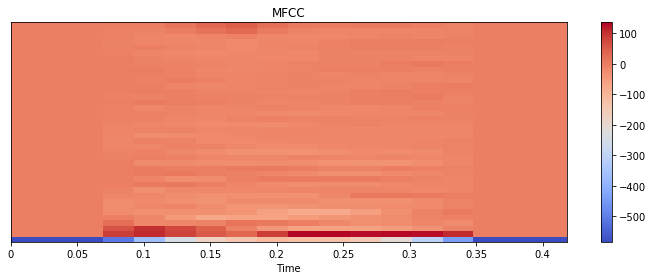

In [164]:
import matplotlib.pyplot as plt
from librosa.display import specshow
plt.figure(figsize=(10, 4))
specshow(test_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

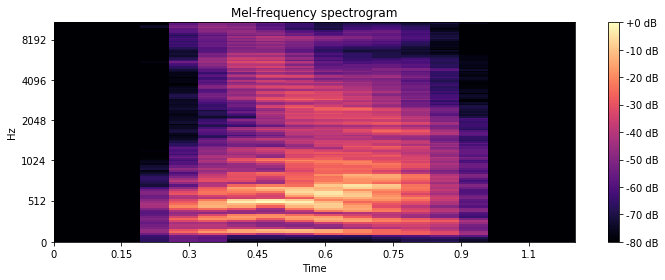

In [165]:
plt.figure(figsize=(10, 4))
test_spect = data_preparation.compute_spectrogram(test)
S_dB = librosa.power_to_db(test_spect, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=8000)
plt.title('Mel-frequency spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [166]:
import librosa
spectrogram = librosa.feature.melspectrogram(y=test,
                                                 sr=8000,
                                                 n_fft=1024,
                                                 hop_length=160)

In [167]:
spectrogram.shape

(128, 57)

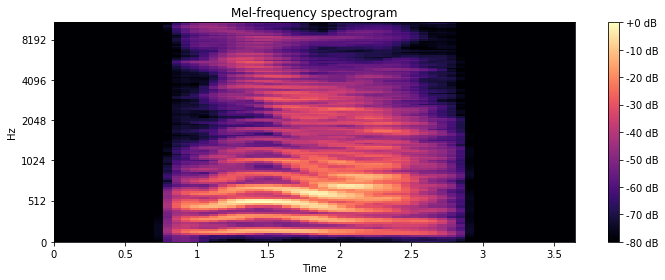

In [168]:
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=8000)
plt.title('Mel-frequency spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()